In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from envelopy import envelopy as enpy
from pkg import pkg
from pkg import save

In [2]:
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

coordenadas = "-48.534679,-22.508117,-48.50481,-22.538879"
x1, y1, x2, y2 = coordenadas.split(",")

datas = "2018-01-01,2020-12-31"
inicio, fim = datas.split(",")
escala = 30
dummy_value = 99999

geom = ee.Geometry.Polygon([[[float(x1),float(y2)],
                             [float(x2),float(y2)],
                             [float(x2),float(y1)],
                             [float(x1),float(y1)],
                             [float(x1),float(y2)]]])


sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filterBounds(geom)\
    .filterDate(inicio,fim)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    
v_emit_asc = sentinel1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
v_emit_desc = sentinel1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

image = ee.Image(dummy_value).blend(v_emit_desc.map(pkg.add_amplitude).select('amplitude').toBands())
image_names = image.bandNames().getInfo()

df = pkg.ee_to_pandas(image, geom, image_names, scale=10)

In [3]:
latitude_central = (float(x1)+float(x2))/2
longitude_central = (float(y1)+float(y2))/2

my_map = geemap.Map(center=(longitude_central, latitude_central), zoom=13)
my_map.addLayer(geom)

rgb = ee.Image.rgb(
    v_emit_desc.mean().select('VV'),
    v_emit_desc.mean().select('VH'),
    v_emit_desc.mean().select('VV').divide(v_emit_desc.mean().select('VH'))
).clip(geom)

my_map.addLayer(rgb, {'min': [-25,-25,0], 'max': [0,0,2]})

my_map

Map(center=[-22.523498, -48.5197445], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=H…

In [4]:
renamed = pkg.rename_geodf(df)
reordered = renamed.reindex(sorted(renamed.columns), axis=1) 

In [5]:
def scale_all(df):
    names = df.columns
    mat = df.to_numpy()
    scaled_mat = (mat - np.mean(mat)) / np.std(mat)
    return pd.DataFrame(scaled_mat, columns=names)

coords = reordered.loc[:, ['latitude','longitude']]

scaled = scale_all(reordered.drop(['latitude','longitude'], axis=1)).join(coords)

In [85]:
test = scaled\
    .drop(['latitude','longitude'], axis=1)\
    .iloc[0,:]\
    .values\
    .reshape((-1,1))

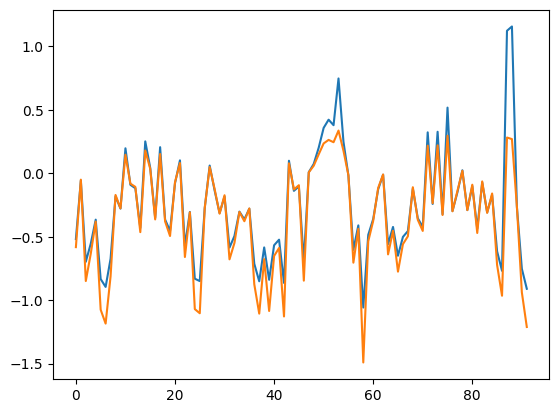

In [100]:
# Extração de um píxel da série
test = scaled\
    .drop(['latitude','longitude'], axis=1)\
    .iloc[0,:]\
    .values\
    .reshape((-1,1))

# Matrix com transformações
xdata = np.concatenate((test, abs(test)**2), axis=1)

# Cálculo do envelope
envelope = enpy.specenv(xdata)

# Extração de coeficientes e da transformação otimizada
b = envelope[envelope[:,1]==max(envelope[:,1]), 2:]
opt = np.sum(xdata*b, axis=1)

# Plot
plt.clf()
plt.plot(test)
plt.plot(opt)
plt.show()

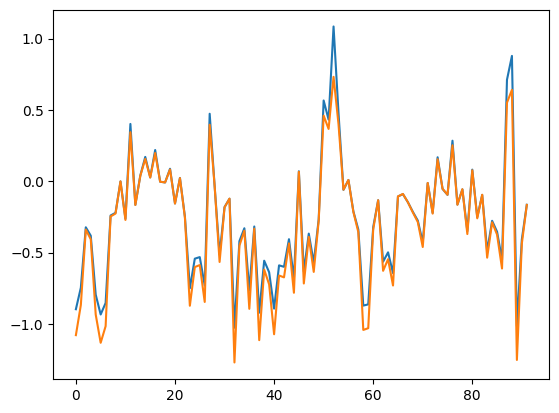

In [101]:
# Extração de um píxel da série
test = scaled\
    .drop(['latitude','longitude'], axis=1)\
    .iloc[10,:]\
    .values\
    .reshape((-1,1))

# Matrix com transformações
xdata = np.concatenate((test, abs(test)**2), axis=1)

# Cálculo do envelope
envelope = enpy.specenv(xdata)

# Extração de coeficientes e da transformação otimizada
b = envelope[envelope[:,1]==max(envelope[:,1]), 2:]
opt = np.sum(xdata*b, axis=1)

# Plot
plt.clf()
plt.plot(test)
plt.plot(opt)
plt.show()

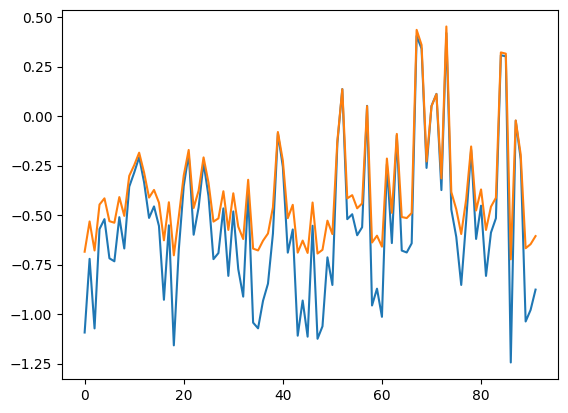

In [102]:
# Extração de um píxel da série
test = scaled\
    .drop(['latitude','longitude'], axis=1)\
    .iloc[100,:]\
    .values\
    .reshape((-1,1))

# Matrix com transformações
xdata = np.concatenate((test, abs(test)**2), axis=1)

# Cálculo do envelope
envelope = enpy.specenv(xdata)

# Extração de coeficientes e da transformação otimizada
b = envelope[envelope[:,1]==max(envelope[:,1]), 2:]
opt = np.sum(xdata*b, axis=1)

# Plot
plt.clf()
plt.plot(test)
plt.plot(opt)
plt.show()

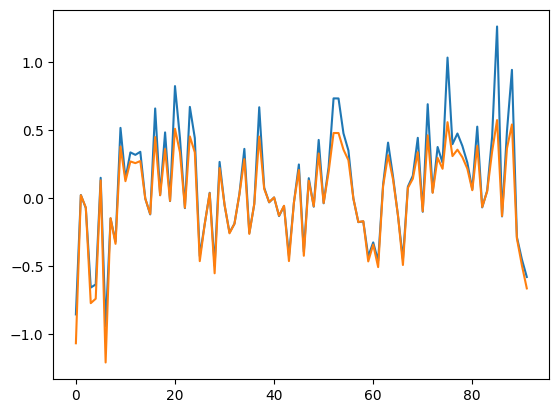

In [103]:
# Extração de um píxel da série
test = scaled\
    .drop(['latitude','longitude'], axis=1)\
    .iloc[1000,:]\
    .values\
    .reshape((-1,1))

# Matrix com transformações
xdata = np.concatenate((test, abs(test)**2), axis=1)

# Cálculo do envelope
envelope = enpy.specenv(xdata)

# Extração de coeficientes e da transformação otimizada
b = envelope[envelope[:,1]==max(envelope[:,1]), 2:]
opt = np.sum(xdata*b, axis=1)

# Plot
plt.clf()
plt.plot(test)
plt.plot(opt)
plt.show()

In [152]:
def spec_opt(x, *args, as_series = False):
    x = np.array(x).flatten()
    xdata = [x] + [i(x) for i in args]
    mat = np.stack(xdata, axis=1)
    envelope = enpy.specenv(mat)
    b = envelope[envelope[:,1]==max(envelope[:,1]), 2:]
    opt = np.sum(mat*b, axis=1)

    if as_series:
        opt = pd.Series(opt)
    
    return opt

spec_opt(test, lambda x: abs(x)**2, as_series=True)

0    -1.070507
1     0.021064
2    -0.069536
3    -0.774812
4    -0.742048
        ...   
87    0.367160
88    0.542768
89   -0.297408
90   -0.493746
91   -0.665947
Length: 92, dtype: float64

In [159]:
optimized = scaled\
    .drop(['latitude', 'longitude'], axis=1)\
    .apply(lambda x: spec_opt(x, lambda y: abs(y)**2, as_series=True))

In [176]:
cols = scaled.drop(['latitude','longitude'], axis=1).columns
path = r'assets/scaled.tif'
save.save_tiff_from_df(scaled, cols, dummy_value, path, "EPSG:4326")

True

In [177]:
optimal = optimized.join(coords)
cols = optimized.columns
path = r'assets/optimized.tif'
save.save_tiff_from_df(optimal, cols, dummy_value, path, "EPSG:4326")

True

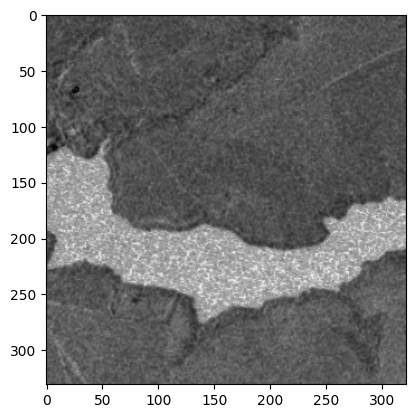

In [180]:
pkg.show_tif('assets/scaled.tif', 10)

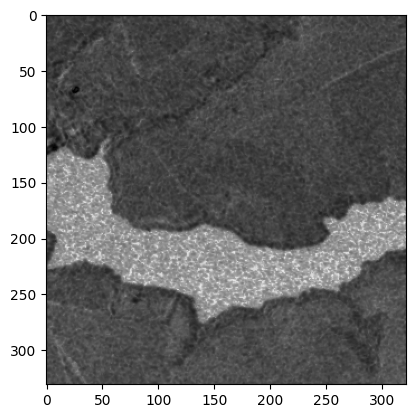

In [181]:
pkg.show_tif('assets/optimized.tif', 10)